## Compound Clustering with RDKit and scikit-fingerprints
### From Bioassay Data to Organized Chemical Space

**Learning objectives**
- Retrieve assay compounds (ChEMBL) or use a small example fallback.
- Standardize molecules and compute fingerprints with RDKit.
- Cluster compounds by fingerprint similarity and relate clusters to activity.

**Prerequisites**
- Python 3.8+
- pandas, numpy, matplotlib, scikit-learn, rdkit, chembl_webresource_client
- Install with: `pip install rdkit-pypi pandas matplotlib scikit-learn chembl-webresource-client`

**Table of contents**
- Introduction & prerequisites
- Data retrieval and cleaning
- Standardization
- Exploratory data analysis (EDA)
- Fingerprinting & clustering
- Interpreting clusters

This tutorial is beginner-friendly and focuses on a practical workflow to organize chemical space for an assay.

### Learning paths
There are two learning paths available:

🟢 **Beginner path**
- focuses on intuition and practical steps
- minimal mathematics
- explains *why* each step is performed

🟡 **Advanced path**
- discusses algorithmic assumptions
- introduces alternatives and caveats
- highlights best practices in cheminformatics

You can follow only the 🟢 sections on a first pass.

In [1]:
import numpy as np
import pandas as pd     
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from src.preprocessing import standardize_smiles

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFingerprintGenerator, DataStructs
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')


In [2]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, radius=2, fpSize=2048, includeChirality=False):
        self.radius = radius
        self.fpSize = fpSize
        self.includeChirality = includeChirality

    def fit(self, X, y=None):
        # nothing to learn — return self
        self._fpgen = rdFingerprintGenerator.GetMorganGenerator(
            radius=self.radius,
            fpSize=self.fpSize,
            includeChirality=self.includeChirality
        )
        return self

    def transform(self, X):
        fps = []
        for mol in X:
            fp = self._fpgen.GetFingerprint(mol)
            arr = np.zeros((self.fpSize,), dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)

        cols = [f"bit_{i}" for i in range(self.fpSize)]
        return pd.DataFrame(fps, columns=cols)

### 🟢 1. Data Acquisition: Bioassay data from ChEMBL

ChEMBL is a curated database of bioactive molecules and their biological targets.

An **assay** in ChEMBL corresponds to a specific biological experiment,
for example measuring inhibition of an enzyme or binding to a receptor.
Therefore, we will now specifically select **one assay** and extract compounds tested in that assay
to cluster them based on chemical similarity.

#### Assay description 

- **Assay ID:** CHEMBL3888087
- **Assay type:** Cell-based, functional
- **Readout:** cAMP levels (TR-FRET)
- **Biological system:**  
  CHO cells expressing a human cannabinoid receptor
- **Measured endpoint:** **EC50 (nM)**

### 🟢 What does it mean?
This assay measures the concentration of a compound required to produce
50% of its maximal effect on intracellular cAMP signaling.

- **Lower EC50 → higher potency**
- **Higher EC50 → lower potency**

In this tutorial, EC50 values are reported in **nanomolar (nM)** units.


In [3]:
# To install the required packages, you can use the following pip command:
# pip install chembl-webresource-client rdkit-pypi

from chembl_webresource_client.new_client import new_client
assay_id = "CHEMBL3888087"


activity = new_client().activity if callable(new_client) else new_client.activity
records = activity.filter(assay_chembl_id=assay_id).only(
            "molecule_chembl_id",
            "canonical_smiles",
            "standard_value",
            "standard_units")
df = pd.DataFrame(records)
df.head()

d:\cheminformatics-tutorials\venv\Lib\site-packages\chembl_webresource_client\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


,canonical_smiles,molecule_chembl_id,standard_units,standard_value,units,value
0,COC(=O)C(C)(C)NC(=O)c1cccc(-c2cccc(Cl)c2)n1,CHEMBL3912120,nM,68.5,nM,68.5
1,COC(=O)C(C)(C)NC(=O)c1cccc(-c2ccccc2Cl)n1,CHEMBL3914266,nM,57.7,nM,57.7
2,Cc1nc(C(C)(C)NC(=O)c2cccc(-c3ccc(Cl)cc3)n2)no1,CHEMBL3939019,nM,340.8,nM,340.8
3,COC(=O)C(C)(C)NC(=O)c1ccc(C)c(OCC(F)(F)F)n1,CHEMBL3952801,nM,77.2,nM,77.2
4,COC(=O)C(C)(C)NC(=O)c1ccc(C2CC2)c(Nc2ccc(Cl)cc...,CHEMBL3891770,nM,434.5,nM,434.5


### 2. Data Cleaning & Simple Transformation

In [4]:
# Basic data cleaning

df = df.dropna(subset=["standard_value","molecule_chembl_id","canonical_smiles"])
df['standard_value'] = df['standard_value'].astype(float)
df = df[df['standard_units'] == 'nM']

EC50 values are often log-normally distributed, so we take the negative log to get a more normal distribution


In [5]:
df['pEC50'] = -np.log10(df['standard_value'] * 1e-9)  # Convert nM to M and take negative log10
df[["standard_value", "pEC50"]].head()

,standard_value,pEC50
0,68.5,7.164309
1,57.7,7.238824
2,340.8,6.467500
3,77.2,7.112383
4,434.5,6.362010


### Molecular standardization

In [6]:
#Show some examples of standardization
df_examples = df.sample(5, random_state=42).copy()

df_examples["smiles_std"] = df_examples["canonical_smiles"].apply(
    lambda s: Chem.MolToSmiles(standardize_smiles(s), canonical=True)
)

df_examples[["canonical_smiles", "smiles_std"]]


,canonical_smiles,smiles_std
280,CC1(COc2nc(C(=O)NC3(c4nccs4)COC3)ccc2Br)COC1,CC1(COc2nc(C(=O)NC3(c4nccs4)COC3)ccc2Br)COC1
248,CCC(CC)(NC(=O)c1ccc(C(F)(F)F)c(OCC2CC2)n1)C(=O)OC,CCC(CC)(NC(=O)c1ccc(C(F)(F)F)c(OCC2CC2)n1)C(=O)OC
218,Cc1nc(C(NC(=O)c2ccc(C3CC3)c(OCC3CCOCC3)n2)C2CC...,Cc1nc(C(NC(=O)c2ccc(C3CC3)c(OCC3CCOCC3)n2)C2CC...
327,NC(=O)[C@@H](NC(=O)c1ccc(C2CC2)c(OCC2CC2)n1)c1...,NC(=O)C(NC(=O)c1ccc(C2CC2)c(OCC2CC2)n1)c1ccc(F...
56,Cc1nc([C@H](CC2CC2)NC(=O)c2ccc(C)c(OCC3CC3)n2)no1,Cc1nc([C@H](CC2CC2)NC(=O)c2ccc(C)c(OCC3CC3)n2)no1


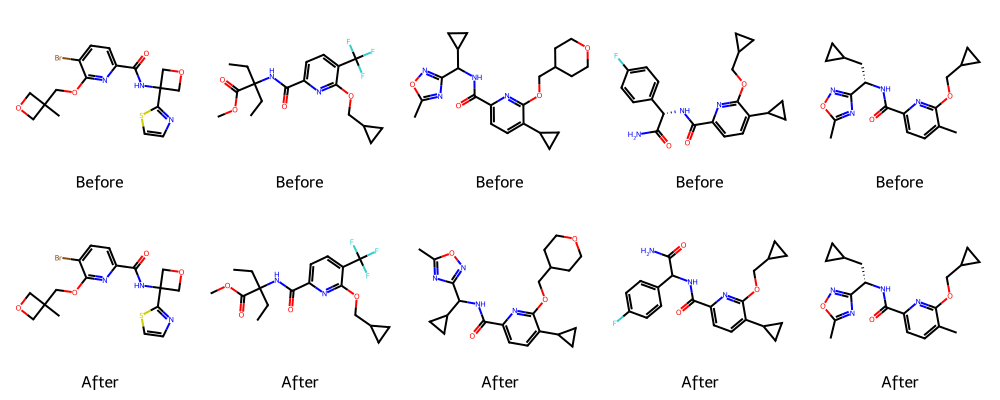

In [7]:
mols_before = [Chem.MolFromSmiles(s) for s in df_examples["canonical_smiles"]]
mols_after = [standardize_smiles(s) for s in df_examples["canonical_smiles"]]

Draw.MolsToGridImage(
    mols_before + mols_after,
    molsPerRow=5,
    subImgSize=(200,200),
    legends=(["Before"] * len(mols_before)) + (["After"] * len(mols_after))
)

### ⚠️ Important note on stereochemistry

During molecular standardization, some compounds may lose
stereochemical (chiral) information.

This typically occurs during **tautomer canonicalization**, which can
change bond orders in a way that makes stereochemistry undefined.
Rather than guessing, RDKit removes stereochemical labels to ensure a
chemically valid representation.

🟢 In this beginner-friendly tutorial, we will accept this behavior, because:
- we focus on scaffold-level similarity
- fingerprint-based clustering often ignores stereochemistry
- our goal is exploratory chemical space analysis

🟡 In workflows where stereochemistry is critical (e.g. enantiomer-
specific activity or 3D modeling), tautomer handling should be applied
with additional care or omitted.

To remain conceptually consistent, we therefore compute
Morgan fingerprints **without stereochemical information**.

This choice prioritizes:
- consistency across molecules
- reproducibility of similarity calculations
- scaffold-level chemical space exploration

Including chirality in fingerprints when stereochemistry is not
consistently defined can lead to misleading comparisons.


In [8]:
df["mol_std"] = df["canonical_smiles"].apply(standardize_smiles)

### 4. Feature Generation: Molecular fingerprints as features for clustering

At this point, we have a clean set of standardized molecules.
The next step is to convert chemical structures into a numerical
representation that can be used by clustering algorithms.

In cheminformatics, this is most commonly done using **molecular fingerprints**.

### 🟢 What is a molecular fingerprint?

A molecular fingerprint is a fixed-length numerical vector that encodes
structural features of a molecule.

For most fingerprints used in clustering:
- each position in the vector is a **bit** (0 or 1)
- a value of 1 indicates the presence of a particular substructure
- the exact chemical meaning of a bit is usually unknown (hashed)

The goal is not interpretability of individual features, but **reliable
similarity comparisons between molecules**.

Why Morgan fingerprints?

In this tutorial, we use **Morgan fingerprints** (also known as ECFP).

Morgan fingerprints are:
- circular (based on local atomic environments)
- insensitive to molecule size
- robust to small structural changes
- widely used in medicinal chemistry

They approximate the idea that:
- molecules with similar local substructures tend to have similar properties

This makes them well-suited for clustering and chemical space exploration.

Key parameters: Radius and fingerprint size

Two key parameters control Morgan fingerprints:

- **radius**: how far from each atom the local environment is considered  
- **fpSize**: the length of the fingerprint vector

In this tutorial we use:
- `radius = 3`
- `fpSize = 4096`

These values provide a good balance between:
- capturing enough chemical detail
- avoiding excessive collisions in the hashed representation

There is no single “correct” choice — parameters should match the scale
and diversity of the dataset.

### 🟡 Advanced note: fingerprints are not learned features

Unlike many machine-learning representations, molecular fingerprints:
- are not learned from data
- do not require training
- are deterministic given a molecule and parameters

They encode chemical intuition accumulated over decades of practice,
not statistical patterns inferred from the dataset.

This is why fingerprints integrate naturally with unsupervised methods.
After fingerprint generation, each molecule is represented as a point
in a high-dimensional binary space.

Clustering algorithms operate on this representation by:
- comparing fingerprints using similarity or distance metrics
- grouping molecules that are closer to each other in this space

In cheminformatics, similarity is most often measured using the
**Tanimoto coefficient**, which is especially suited for sparse binary vectors.

### 🟢 Important limitations to keep in mind

Molecular fingerprints:
- do not encode 3D structure
- do not capture conformational flexibility
- may miss long-range electronic effects

As a result:
- clustering reflects **structural similarity**, not guaranteed
- similarity in biological mechanism or potency

This distinction is critical when interpreting results.



In [9]:
fp_transformer = MorganFingerprintTransformer(
    radius=3,
    fpSize=4096,
    includeChirality=False
)

X_fps = fp_transformer.fit_transform(df["mol_std"])
X_fps.head()

# or alternatively, using RDKIT directly
df["fp_rdkit"] = df["mol_std"].apply(
    lambda m: AllChem.GetMorganFingerprintAsBitVect(
        m,
        radius=3,
        nBits=4096,
        useChirality=False
    )
)

I use a transformer to generate ML-ready fingerprint matrices, but I also keep RDKit fingerprint objects for similarity-based clustering methods like Taylor–Butina, which rely on Tanimoto similarity.

Since we already have a feature matrix, now we can switch our focus to topics related to chemical similarity of compounds in our dataset. Using distance metrics can help to quantify structural dissimilarity between molecules according to a chosen fingerprint representation. 

Visualizing distances helps us:
- asess chemical diversity
- decide whether clustering is an appropriate technique
- choose suitable clustering parameters
- interpret cluster compactness 

Distance plots do not show "true chemical space", but they provide us with essential intuition for clustering behavior. 

d:\cheminformatics-tutorials\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2459: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


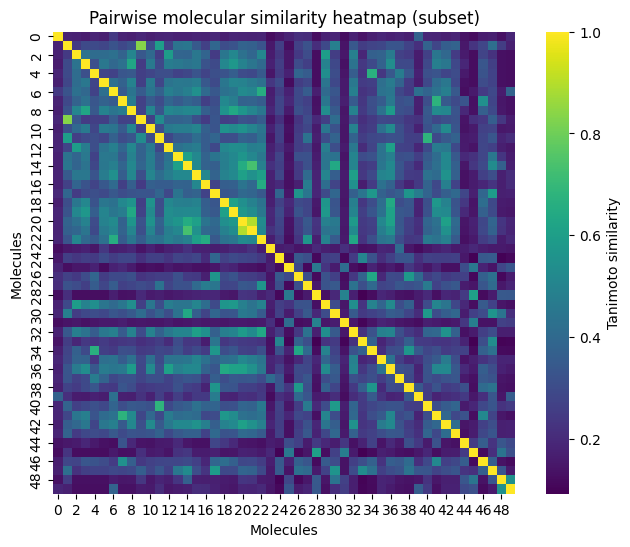

In [10]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Pairwise Tanimoto distance
D = pairwise_distances(X_fps.values, metric="jaccard")
S = 1.0 - D

# Subsample for visualization
np.random.seed(42)
n = 50
idx = np.random.choice(S.shape[0], size=n, replace=False)
S_sub = S[np.ix_(idx, idx)]

plt.figure(figsize=(8, 6))
sns.heatmap(
    S_sub,
    cmap="viridis",
    square=True,
    cbar_kws={"label": "Tanimoto similarity"},
)
plt.title("Pairwise molecular similarity heatmap (subset)")
plt.xlabel("Molecules")
plt.ylabel("Molecules")
plt.show()


### 5. Clustering Methods 


In this section, we explore three unsupervised clustering approaches particularly useful in cheminformatics:

- **Taylor-Butina Clustering**, a distance-based method operating on molecular fingerprints, providing interpretable similarity thresholds
- **BIRCH-based Clustering**, which enables efficient hierarchicl clustering and scales well to larger compound collections
- **HDBSCAN**, a density-based clustering algorithm capable of identifying clusters of varying density and labeling noise points

These methods are used to group compounds based on structural similaritz and to explore the organization of chemical space. 
Such comparative approach will (hopefully) provide a more robust understanding of the chemical space organization. 

### A. Taylor-Butina Clustering

RDKIT's implementation based on the algorithm published in: Butina JCICS 39 747-750 (1999)
- This method relies on a principle that compound similarity can be used to group molecules together and leveraged to explain their e.g. biological activity 
- It was developed to identify smaller but homogeneous clusters, where cluster centroid (at least) will be more similar than a selected threshold to other molecules in the cluster

In [11]:
from rdkit.ML.Cluster import Butina
from src.utils import tanimoto_distance_matrix

fps_rdkit = df["fp_rdkit"].tolist()
dist_matrix = tanimoto_distance_matrix(fps_rdkit)

clusters_tb = Butina.ClusterData(
    dist_matrix,
    nPts=len(fps_rdkit),
    distThresh=0.3,   
    isDistData=True
)
df["cluster_taylor_butina"] = -1
for cluster_id, cluster in enumerate(clusters_tb):
    for idx in cluster:
        df.loc[idx, "cluster_taylor_butina"] = cluster_id

B. BIT-BIRCH